# 🔍 NAPTRON Demo: Aktywne Uczenie w Detekcji Obiektów
Pokazujemy działanie algorytmu NAPTRON z wykorzystaniem modelu Faster R-CNN i zbioru PASCAL VOC 2007.

In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
import numpy as np

c:\Users\Rafal\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🔧 Przygotowanie modelu i urządzenia

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

c:\Users\Rafal\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rafal\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## 📥 Pobranie i przygotowanie zbioru danych

In [3]:
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset, DataLoader

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COCO_CLASS_TO_IDX = {name: idx for idx, name in enumerate(COCO_INSTANCE_CATEGORY_NAMES)}

def transform_image(image):
    return TF.to_tensor(image)

class VOCDatasetWrapper(Dataset):
    def __init__(self, root, year='2007', image_set='train', allowed_classes=('dog', 'person'), max_samples=None):
        full_dataset = VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.allowed_classes = set(allowed_classes)

        self.filtered_data = []
        for image, target in full_dataset:
            objects = target['annotation'].get('object', [])
            if not isinstance(objects, list):
                objects = [objects]

            if any(obj['name'] in self.allowed_classes for obj in objects):
                self.filtered_data.append((image, target))
                if max_samples is not None and len(self.filtered_data) >= max_samples:
                    break

        print(f"[INFO] Zbiór '{image_set}' ({year}) zawiera {len(self.filtered_data)} przykładów z klas: {allowed_classes}")

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        image, target = self.filtered_data[idx]
        image = transform_image(image)
        return image, target


# Ustawiamy limit obrazów na szybkie testy
train_dataset = VOCDatasetWrapper('./data', year='2007', image_set='train', allowed_classes=('dog', 'person'), max_samples=10)
test_dataset = VOCDatasetWrapper('./data', year='2007', image_set='val', allowed_classes=('dog', 'person'), max_samples=5)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))



Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data
[INFO] Zbiór 'train' (2007) zawiera 10 przykładów z klas: ('dog', 'person')
Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data
[INFO] Zbiór 'val' (2007) zawiera 5 przykładów z klas: ('dog', 'person')


## 🧠 Implementacja NAPTRON (prosta wersja)

In [7]:
import torch
import torchvision.transforms.functional as F
class NAPTRON:
    def __init__(self, model, layer_name="backbone.body.layer3.2.relu", device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.layer_name = layer_name
        self.nap_memory = {}  # M_c dla każdej klasy c
        self.activations = []

        print(f"[INIT] Szukam warstwy '{layer_name}'...")
        layer = dict([*self.model.named_modules()]).get(layer_name, None)
        if layer is None:
            raise ValueError(f"Warstwa {layer_name} nie znaleziona w modelu.")
        layer.register_forward_hook(self._hook)
        print(f"[INIT] Hook zarejestrowany na warstwie: {layer_name}")

    def _hook(self, module, input, output):
        # Czyszczenie poprzednich aktywacji i zapisywanie aktualnych
        self.activations.append(output)
        print("[HOOK] Aktywacje zostały zapisane.")

    def extract_nap(self, x: torch.Tensor) -> torch.Tensor:
        print("[extract_nap] Rozpoczynam wyciąganie NAP...")
        self.activations = []
        _ = self.model(x)
        if not self.activations:
            raise RuntimeError("[extract_nap] Nie znaleziono aktywacji.")
        nap = self.activations[-1].detach().clone()

        # Binarizacja - ReLU zero lub więcej → binarizacja na > 0
        nap_binary = (nap > 0).float()  # można też .to(torch.uint8)
        # Spłaszczamy każdą próbkę do 1-wymiarowego wektora
        nap_vector = nap_binary.view(nap_binary.size(0), -1)

        print(f"[extract_nap] Binarne wektory mają rozmiar: {nap_vector.shape}")
        print(f"[extract_nap] Przykładowy wektor NAP: {nap_vector[0].cpu().numpy()[:30]}...")
        return nap_vector

    def add_to_memory(self, images, annotations):
        print("[add_to_memory] Dodaję NAPy na podstawie ground truth (VOC-style)...")
        images = images.to(self.device)
        with torch.no_grad():
            for i, ann in enumerate(annotations):
                objects = ann['annotation'].get('object', [])
                if not isinstance(objects, list):  # jeden obiekt jako dict → lista
                    objects = [objects]

                for obj in objects:
                    class_name = obj['name']
                    if class_name not in COCO_CLASS_TO_IDX:
                        print(f"[WARN] Klasa {class_name} nie istnieje w COCO. Pomijam.")
                        continue
                    class_idx = COCO_CLASS_TO_IDX[class_name]

                    # Wyciągnij bbox i wytnij region
                    bbox = obj['bndbox']
                    x1, y1 = int(bbox['xmin']), int(bbox['ymin'])
                    x2, y2 = int(bbox['xmax']), int(bbox['ymax'])

                    # Wytnij region z obrazu i zresize'uj
                    crop = F.resized_crop(images[i], y1, x1, y2 - y1, x2 - x1, size=(224, 224))
                    crop = crop.unsqueeze(0)  # batch=1

                    # Wyciągnij NAP z wycinka
                    nap = self.extract_nap(crop)[0].detach().cpu()

                    self.nap_memory.setdefault(class_idx, []).append(nap)
                    print(f"[add_to_memory] Dodano NAP do klasy {class_name} ({class_idx}). Liczba NAPów: {len(self.nap_memory[class_idx])}")


    def hamming_distance(self, a, b):
        """
        Oblicza średnią różnicę bitów między dwoma tensorami binarnymi (Hamming).
        """
        b = b.to(a.device)
        dist = (a != b).float().mean().item()
        return dist

    def compute_uncertainty(self, images):
        """
        Dla każdego NAP w images oblicza niepewność - minimalną odległość Hamminga
        do najbliższego NAP w pamięci danej klasy.
        """
        print("[compute_uncertainty] Rozpoczynam obliczanie niepewności...")
        images = images.to(self.device)
        with torch.no_grad():
            outputs = self.model(images)
            print("[compute_uncertainty] Uzyskano outputs z modelu.")
            naps = self.extract_nap(images)

            results = []
            for i, output in enumerate(outputs):
                print(f"[compute_uncertainty] Przetwarzam obraz {i}...")
                for j, label in enumerate(output['labels']):
                    c = label.item()
                    score = output['scores'][j].item()
                    print(f"[compute_uncertainty] Klasa: {c}, Score: {score:.3f}")
                    if score > 0.5:
                        nap = naps[i]
                        memory = self.nap_memory.get(c, [])
                        if not memory:
                            phi = 1.0
                            print(f"[compute_uncertainty] Brak pamięci dla klasy {c}. Phi=1.0")
                        else:
                            distances = [self.hamming_distance(nap, m) for m in memory]
                            phi = min(distances)
                            print(f"[compute_uncertainty] Najmniejsza odległość Hamminga dla klasy {c}: {phi:.4f}")
                        results.append((c, phi))
            return results


## 🧪 Faza treningu: Zbieranie NAPów

[INIT] Szukam warstwy 'backbone.body.layer3.2.relu'...
[INIT] Hook zarejestrowany na warstwie: backbone.body.layer3.2.relu

[INFO] Przetwarzam batch 1/5


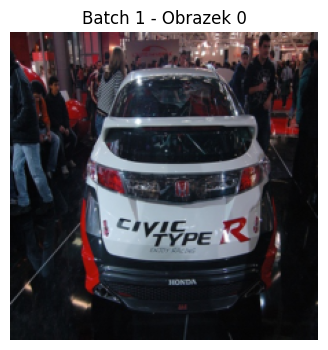

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


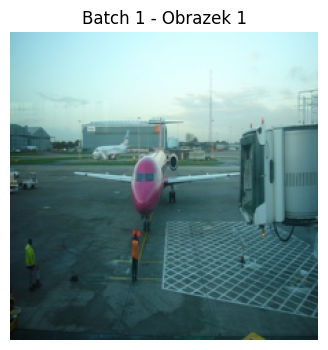

[add_to_memory] Dodaję NAPy na podstawie ground truth (VOC-style)...
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy car (3). Liczba NAPów: 1
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 1
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje został

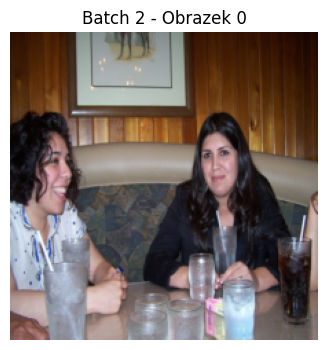

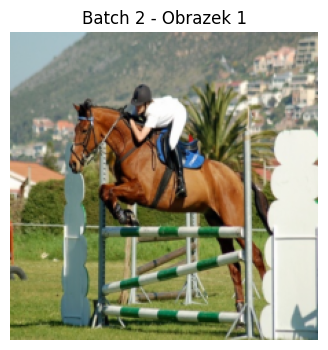

[add_to_memory] Dodaję NAPy na podstawie ground truth (VOC-style)...
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 8
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 9
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 11
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy horse (18). Liczba NAPów: 1

[INFO] Przetwarzam batch 3/5


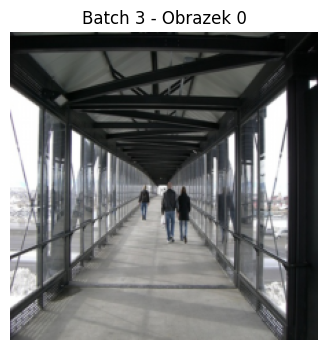

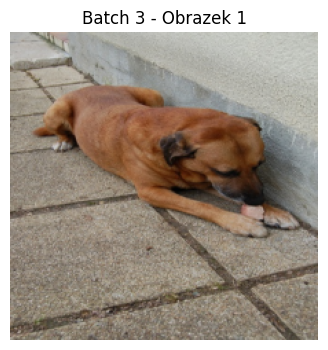

[add_to_memory] Dodaję NAPy na podstawie ground truth (VOC-style)...
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 12
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 13
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje z

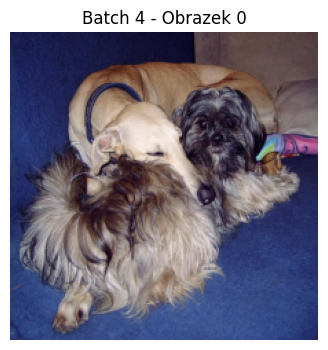

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


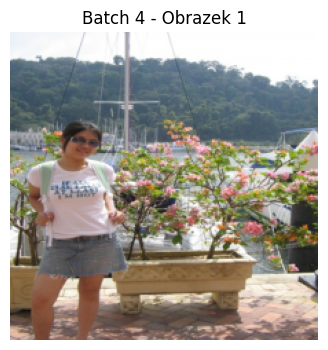

[add_to_memory] Dodaję NAPy na podstawie ground truth (VOC-style)...
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy dog (17). Liczba NAPów: 2
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy dog (17). Liczba NAPów: 3
[WARN] Klasa pottedplant nie istnieje w COCO. Pomijam.
[WARN] Klasa pottedplant nie istnieje w COCO. Po

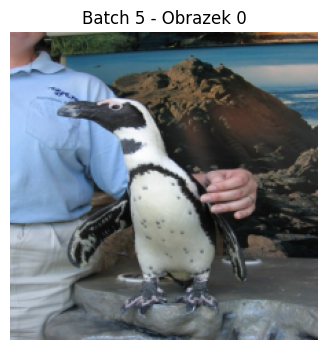

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


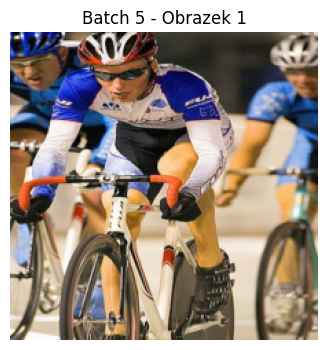

[add_to_memory] Dodaję NAPy na podstawie ground truth (VOC-style)...
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy bird (15). Liczba NAPów: 1
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0.]...
[add_to_memory] Dodano NAP do klasy person (1). Liczba NAPów: 16
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zos

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision import transforms as T
resize_transform = T.Resize((224, 224))
naptron = NAPTRON(model, device=device)

max_batches = 5

for batch_idx, (imgs, anns) in enumerate(train_loader):
    if batch_idx >= max_batches:
        break

    print(f"\n[INFO] Przetwarzam batch {batch_idx + 1}/{max_batches}")

    # Resize każdego obrazu
    imgs_resized = [resize_transform(img) for img in imgs]  # img to tensor [C,H,W]

    # Wyświetlamy obrazki
    for i, img_t in enumerate(imgs_resized):
        img_np = img_t.cpu().permute(1, 2, 0).numpy()
        plt.figure(figsize=(4, 4))
        plt.title(f"Batch {batch_idx + 1} - Obrazek {i}")
        plt.imshow(img_np)
        plt.axis('off')
        plt.show()

    # Stack i na GPU
    imgs_tensor = torch.stack(imgs_resized).to(device)

    # Dodaj NAP do pamięci
    naptron.add_to_memory(imgs_tensor, anns)

print("\n[INFO] Zebrano NAPy dla klas:", list(naptron.nap_memory.keys()))


## 🖼️ Wizualizacja wyników: obraz, bbox, niepewność, NAP

[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[INFO] Uzyskano output z modelu.
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0.]...
[INFO] Klasa person: min Hamming distance=0.3709
[DETECTION 0] Class=person, Score=1.00, Uncertainty=0.37
[extract_nap] Rozpoczynam wyciąganie NAP...
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[HOOK] Aktywacje zostały zapisane.
[extract_nap] Binarne wektory mają rozmiar: torch.Size([1, 2560000])
[extract_nap] Przykładowy wektor NAP: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]...
[INFO] Klasa person: min Hamming distance=0.3775
[DE

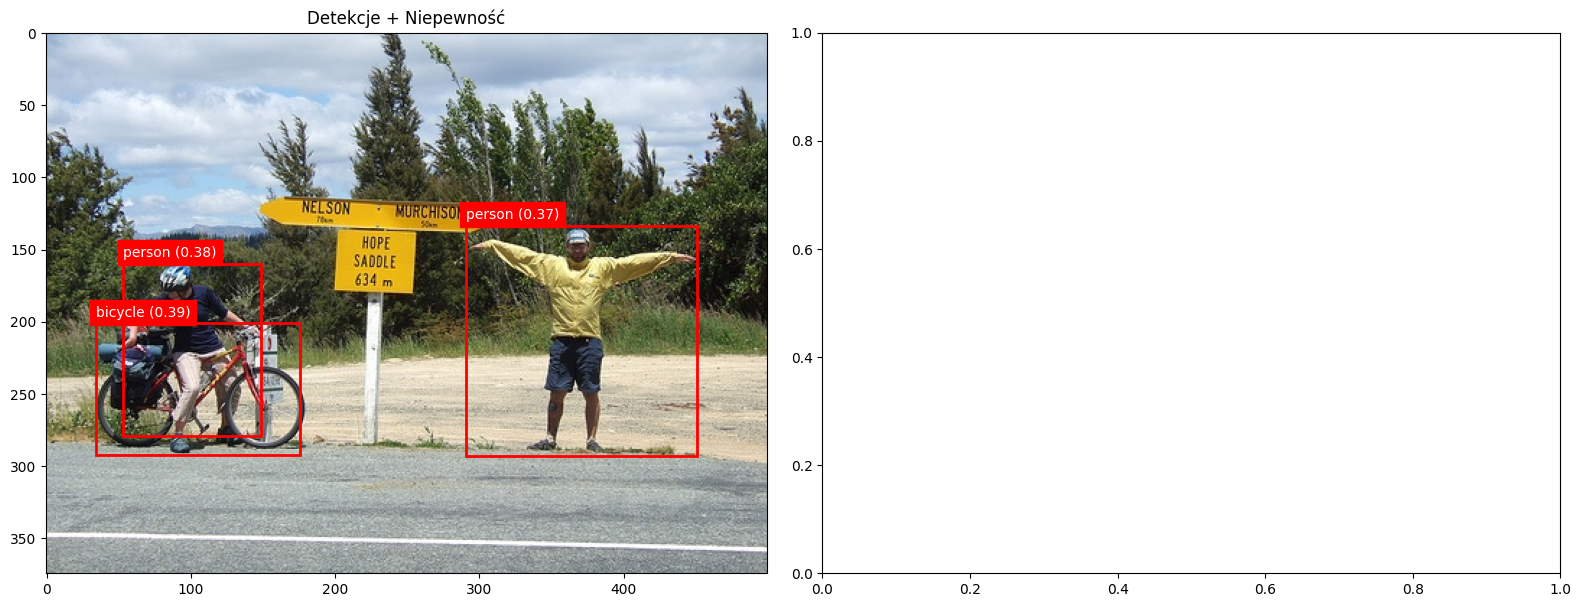

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

CLASS_NAMES = COCO_INSTANCE_CATEGORY_NAMES

# Pobierz przykładowy batch
imgs, _ = next(iter(test_loader))
img = imgs[0].to(device)

with torch.no_grad():
    # Wyniki detekcji
    output = model([img])[0]
    print("[INFO] Uzyskano output z modelu.")

    # Nie wyciągamy NAP z całego obrazu!
    # Usuwamy tę linię:
    # nap = naptron.extract_nap(img.unsqueeze(0))  # -> shape (1, C)

# Przygotuj wykresy
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
img_np = img.cpu().permute(1, 2, 0).numpy()
ax[0].imshow(img_np)
ax[0].set_title("Detekcje + Niepewność")

for i, box in enumerate(output['boxes']):
    score = output['scores'][i].item()
    if score < 0.5:
        continue
    label = output['labels'][i].item()
    cls_name = CLASS_NAMES[label] if label < len(CLASS_NAMES) else f"Class {label}"
    # if cls_name not in ['dog', 'person']:
    #     continue  # Tylko psy i ludzie

    # --- NOWOŚĆ: wycinamy obiekt wg bounding box i resize ---
    x1, y1, x2, y2 = map(int, box.cpu().numpy())
    obj_crop = F.resized_crop(img, y1, x1, y2 - y1, x2 - x1, size=(224, 224))
    obj_crop = obj_crop.unsqueeze(0).to(device)

    # Wyciągamy NAP tylko z tego wycinka (1 obiekt)
    nap_vec = naptron.extract_nap(obj_crop)[0]

    mem = naptron.nap_memory.get(label, [])
    if not mem:
        unc = 1.0
        print(f"[INFO] Brak pamięci dla klasy {cls_name}. Niepewność=1.0")
    else:
        distances = [naptron.hamming_distance(nap_vec, m) for m in mem]
        unc = min(distances)
        print(f"[INFO] Klasa {cls_name}: min Hamming distance={unc:.4f}")

    # Rysuj box i opis
    x1f, y1f, x2f, y2f = box.cpu().numpy()
    rect = patches.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].text(x1f, y1f - 5, f"{cls_name} ({unc:.2f})", color='white', backgroundcolor='red', fontsize=10)

    print(f"[DETECTION {i}] Class={cls_name}, Score={score:.2f}, Uncertainty={unc:.2f}")

# Jeżeli chcesz, możesz zostawić NAP z całego obrazu do wizualizacji (opcjonalnie)
# ale w Twoim kodzie aktualnie NAP jest z całego obrazu, więc można go pominąć lub zrobić analogicznie dla ROI

plt.tight_layout()
plt.show()



